In [1]:
# AUTHORS
# - Mohammed Al-Jaff
# - Joel Olofsson
# - Carl Öhrnell

# COURSE
# Advanced Probabilistic Machine Learning 
# 5hp, -ht20
# Uppsala University 

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import truncnorm
import time
import csv


def get_s_cond_t_params(player_1_sigma, player_2_sigma, player_1_mean, player_2_mean, t_i):
    beta = 3  # från uppgiften

    # Covariance calculations
    covariance_t_given_s = beta
    covariance_ss = np.array([[player_1_sigma, 0], [0, player_2_sigma]])
    A = np.array([1, -1]).reshape([1, 2])
    inv_covariance_ss = np.linalg.inv(covariance_ss)
    ACA = np.matmul(A.T, A) * (1 / covariance_t_given_s)
    covariance_s_cond_t = np.linalg.inv(inv_covariance_ss + ACA)

    # Mean calculations
    player_means = np.array([player_1_mean, player_2_mean]).reshape([2, 1])
    a = covariance_s_cond_t
    b = np.matmul(inv_covariance_ss, player_means)
    c = A.T * (1 / covariance_t_given_s) * t_i
    mean_s_cond_t = np.matmul(a, b + c)

    return mean_s_cond_t, covariance_s_cond_t


def P_s_cond_t(t_i, player_1_mean, player_1_sigma, player_2_mean, player_2_sigma):
    # player_1_mean = 25; player_2_mean = 25; player_1_sigma = 8.3**2; player_2_sigma = 8.3**2

    mean_s_cond_t, cov_s_cond_t = get_s_cond_t_params(player_1_mean=player_1_mean, player_1_sigma=player_1_sigma,
                                                      player_2_mean=player_2_mean, player_2_sigma=player_2_sigma,
                                                      t_i=t_i)

    return np.random.multivariate_normal(mean=mean_s_cond_t.reshape(2), cov=cov_s_cond_t,
                                         check_valid='warn', tol=1e-8)

def P_t_cond_s(s_i, t_game):
    s_diff = s_i[0] - s_i[1]
    beta = 3
    t_sigma = beta

    if t_game > 0:  # case for when y=1
        a, b = (0 - s_diff) / t_sigma, np.inf
        t = truncnorm.rvs(a, b) * t_sigma + s_diff
        return t
    elif t_game < 0:  # case for when y=-1
        a, b = -np.inf, (0 - s_diff) / t_sigma
        t = truncnorm.rvs(a, b) * t_sigma + s_diff
        return t
    else:
        print("ERROR, TIES PRESENTLY NOT ALLOWED")


        
def gibbs_sampler(L, player_1_stats, player_2_stats, t_game):
    player_1_mean, player_1_sigma = player_1_stats
    player_2_mean, player_2_sigma = player_2_stats
    
    s_i = [player_1_mean, player_2_mean]

    t_obs = np.zeros(L)
    s_obs = np.zeros([L, 2])

    for i in range(L):
        t_i_plus_1 = P_t_cond_s(s_i, t_game=t_game)
        s_i_plus_1 = P_s_cond_t(t_i_plus_1, player_1_mean, player_1_sigma, player_2_mean, player_2_sigma)

        t_obs[i] = t_i_plus_1
        s_obs[i, :] = s_i_plus_1

        s_i = s_i_plus_1
        # plt.scatter(s_obs[:, 0], s_obs[:, 1])
        # plt.pause(0.1)
    # plt.show()

    # plt.plot(s_obs[:, 0]); plt.plot(s_obs[:, 1]); plt.show()
    return s_obs, t_obs



def player_stats_estimate_from_obs(s_obs):
    player_1_stats_estimate = [np.mean(s_obs[:, 0]), np.var(s_obs[:, 0])] # [mean, variance] of samples
    player_2_stats_estimate = [np.mean(s_obs[:, 1]), np.var(s_obs[:, 1])] # [mean, variance] of samples
    
    return player_1_stats_estimate, player_2_stats_estimate


    

def make_stats_dictionary(filename, stats_dictionary, printable):
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        mean = 100; variance = (100 / 3) ** 2  # TrueSkill prior parameters before any games
        gamelist = []
        for row in reader:
            # Create dictionary (=map) with keyword 'team' and value [mean, variance]
            stats_dictionary[row['team1']] = [mean, variance]
            # Add teams and result to list
            gamelist.append([row['team1'], row['team2'], int(row['score1']) - int(row['score2'])])

            if printable == 1:  # Print the whole list
                print(f"{row['team1']} vs {row['team2']}: {row['score1']}-{row['score2']}")  # Access by column header
                      
    #stats_dictionary = random.shuffle(stats_dictionary, random)

    return stats_dictionary, gamelist



# Ranking by mean (should perhaps be improved to mean - 3 * sigma)
def ranking(stats_dictionary):
    sorted_teams = sorted(stats_dictionary.items(), key=lambda x: x[1], reverse=True)
    print("\nList of teams ranked by mean skill in descending order:\n")
    for i in sorted_teams:
        print(i[0], i[1])

        
def predict_winner(team1_string, team2_string, stats_dictionary):
    diff = stats_dictionary[team1_string][0] - stats_dictionary[team2_string][0] 
    #print('statdic team1 : ', stats_dictionary[team1_string][0])
    #print('statdic team2 : ', stats_dictionary[team2_string][0])
    print('\t diff: ', diff)
    
    if diff > 0:
        return 1
    elif diff < 0:
        return -1
    else:
        return 1
            


In [2]:
# Make dictionary of team stats (mean and variance) & list of all games with result
stats_dictionary, result_list = make_stats_dictionary('SerieA.csv', stats_dictionary={}, printable=0)


In [3]:
stats_dictionary

{'Chievo': [100, 1111.1111111111113],
 'Lazio': [100, 1111.1111111111113],
 'Torino': [100, 1111.1111111111113],
 'Sassuolo': [100, 1111.1111111111113],
 'Parma': [100, 1111.1111111111113],
 'Empoli': [100, 1111.1111111111113],
 'Bologna': [100, 1111.1111111111113],
 'Atalanta': [100, 1111.1111111111113],
 'Juventus': [100, 1111.1111111111113],
 'Napoli': [100, 1111.1111111111113],
 'Spal': [100, 1111.1111111111113],
 'Udinese': [100, 1111.1111111111113],
 'Inter': [100, 1111.1111111111113],
 'Genoa': [100, 1111.1111111111113],
 'Frosinone': [100, 1111.1111111111113],
 'Fiorentina': [100, 1111.1111111111113],
 'Cagliari': [100, 1111.1111111111113],
 'Roma': [100, 1111.1111111111113],
 'Milan': [100, 1111.1111111111113],
 'Sampdoria': [100, 1111.1111111111113]}

In [ ]:
result_list

In [ ]:

# Make dictionary of team stats (mean and variance) & list of all games with result
stats_dictionary, result_list = make_stats_dictionary('SerieA.csv', stats_dictionary={}, printable=0)

correct_predictions = 0
nr_of_draws = 0

''' 
UNCOMMENT THIS SECTION TO GET A RANDOMIXED ORDERING OF THE MATCHES. 
# 
If you want to randomize

'''

#x = np.random.choice(range(len(result_list)), size=len(result_list), replace=False)
#randomized_list = []
#for i in x:
#    randomized_list.append(result_list[i])
#result_list = randomized_list[:250]

result_list = result_list[:250]
for i in range(len(result_list)):
    # result_list holds [team1, team2, result = score1 - score2]
    print(f"\nResult game {i}:   {result_list[i]}")
    team1 = result_list[i][0]
    team2 = result_list[i][1]
    
    print('team1: ', team1)
    print('team2: ', team2)
    result = result_list[i][2]
    
    # stats_dictionary with keyword 'teamname' and value [mean, variance]
    print(f"Stats before game: {stats_dictionary[team1]}, {stats_dictionary[team2]}")

    if result == 0:  # ignore tied games for now
        print("Game ignored due to tie")
        print(f"Stats after game:  {stats_dictionary[team1]}, {stats_dictionary[team2]}")
        nr_of_draws += 1
        print("Draws: ", nr_of_draws)
    else:
    
        # prediktera mat resultat och spara prediktion
        pred_result = predict_winner(team1, team2, stats_dictionary)
        
        if np.sign(result) == np.sign(pred_result):
                correct_predictions += 1
                print("Correct pred: ", correct_predictions)
        
        print('true result: ', result)
        print('pred result: ', pred_result)
                
        s_obs, t_obs =  gibbs_sampler(L=5000,
                                      player_1_stats=stats_dictionary[team1], 
                                      player_2_stats=stats_dictionary[team2],
                                      t_game=result)
        
        player_1_stats_posterior, player_2_stats_posterior = player_stats_estimate_from_obs(s_obs[3000:, :])
        
        
        # Update team stats so posterior makes new prior
        stats_dictionary[team1] = player_1_stats_posterior
        stats_dictionary[team2] = player_2_stats_posterior


        print(f"Stats AFTER game: {stats_dictionary[team1]}, {stats_dictionary[team2]}")

print()
print("correct_predictions ", correct_predictions)
print("reslist: ", len(result_list))
print("draws: ", nr_of_draws)
print('performance: ', correct_predictions / (len(result_list)-nr_of_draws))


In [4]:
# Q5 NOTES. 

'''
#Running this procedure again resulted in a similar raking with only slight differences in the final ordering of the teams, when ordered by thier estimated skill.
# In figure xxx we have present the teams ranked accorind to their estimaetd skills for two runs. 


Q:  How can you interpret the variance of the final skills? 
Since TrueSkill beased models are baysian in anture when it comes to a players skill, the variances accosiated with thier skill reflects the models/systsm degree of cetianty
of thier true skills. In other words, the variance is a measure of how sure we are of the skill mean estimate. 

'''




'\n#Running this procedure again resulted in a similar raking with only slight differences in the final ordering of the teams, when ordered by thier estimated skill.\n# In figure xxx we have present the teams ranked accorind to their estimaetd skills for two runs. \n\n\nQ:  How can you interpret the variance of the final skills? \nSince TrueSkill beased models are baysian in anture when it comes to a players skill, the variances accosiated with thier skill reflects the models/systsm degree of cetianty\nof thier true skills. In other words, the variance is a measure of how sure we are of the skill mean estimate. \n\n'

In [5]:
stats_dictionary


{'Chievo': [100, 1111.1111111111113],
 'Lazio': [100, 1111.1111111111113],
 'Torino': [100, 1111.1111111111113],
 'Sassuolo': [100, 1111.1111111111113],
 'Parma': [100, 1111.1111111111113],
 'Empoli': [100, 1111.1111111111113],
 'Bologna': [100, 1111.1111111111113],
 'Atalanta': [100, 1111.1111111111113],
 'Juventus': [100, 1111.1111111111113],
 'Napoli': [100, 1111.1111111111113],
 'Spal': [100, 1111.1111111111113],
 'Udinese': [100, 1111.1111111111113],
 'Inter': [100, 1111.1111111111113],
 'Genoa': [100, 1111.1111111111113],
 'Frosinone': [100, 1111.1111111111113],
 'Fiorentina': [100, 1111.1111111111113],
 'Cagliari': [100, 1111.1111111111113],
 'Roma': [100, 1111.1111111111113],
 'Milan': [100, 1111.1111111111113],
 'Sampdoria': [100, 1111.1111111111113]}

In [6]:
ranking(stats_dictionary)
'fjärde (randomiserad) körningen'


List of teams ranked by mean skill in descending order:

Chievo [100, 1111.1111111111113]
Lazio [100, 1111.1111111111113]
Torino [100, 1111.1111111111113]
Sassuolo [100, 1111.1111111111113]
Parma [100, 1111.1111111111113]
Empoli [100, 1111.1111111111113]
Bologna [100, 1111.1111111111113]
Atalanta [100, 1111.1111111111113]
Juventus [100, 1111.1111111111113]
Napoli [100, 1111.1111111111113]
Spal [100, 1111.1111111111113]
Udinese [100, 1111.1111111111113]
Inter [100, 1111.1111111111113]
Genoa [100, 1111.1111111111113]
Frosinone [100, 1111.1111111111113]
Fiorentina [100, 1111.1111111111113]
Cagliari [100, 1111.1111111111113]
Roma [100, 1111.1111111111113]
Milan [100, 1111.1111111111113]
Sampdoria [100, 1111.1111111111113]


'fjärde (randomiserad) körningen'

In [7]:
# Q4a 
nr_of_samples = 50000

player_1_mean = 100
player_1_var = 10
player_1_stats = [player_1_mean, player_1_var]

player_2_mean = 100
player_2_var = 10
player_2_stats = [player_2_mean, player_2_var]

match_outcome = 1 # player 1 wins

s_obs_1, t_obs_1 = gibbs_sampler(L=nr_of_samples,
                             player_1_stats=player_1_stats,
                             player_2_stats=player_2_stats,
                             t_game=match_outcome)
print('1 done')

s_obs_2, t_obs_2 = gibbs_sampler(L=nr_of_samples,
                             player_1_stats=player_1_stats,
                             player_2_stats=player_2_stats,
                             t_game=match_outcome)
print('2 done')

s_obs_3, t_obs_3 = gibbs_sampler(L=nr_of_samples,
                             player_1_stats=player_1_stats,
                             player_2_stats=player_2_stats,
                             t_game=match_outcome)
print('3 done')

1 done
2 done
3 done


Text(0, 0.5, 'mean skill estimate up to ith sample (arbitrary units)')

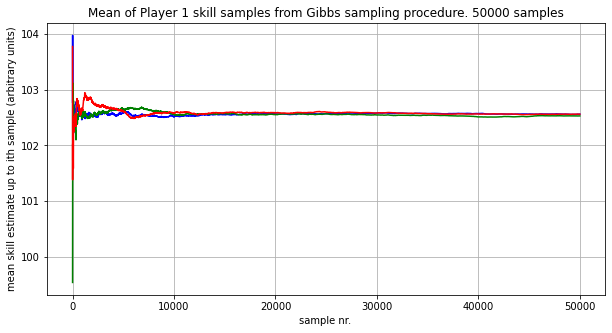

In [14]:

#plotting mean of all observed values up until the i'th obs

mean_vector_1 = np.cumsum(s_obs_1[:,0])/(np.array(list(range(len(s_obs_1[:,0]))))+1)
mean_vector_2 = np.cumsum(s_obs_2[:,0])/(np.array(list(range(len(s_obs_2[:,0]))))+1)
mean_vector_3 = np.cumsum(s_obs_3[:,0])/(np.array(list(range(len(s_obs_3[:,0]))))+1)

plt.figure(figsize=[10,5])
plt.grid()
plt.plot(mean_vector_1, color='blue')
plt.plot(mean_vector_2, color='green')
plt.plot(mean_vector_3, color='red')
plt.title('Mean of Player 1 skill samples from Gibbs sampling procedure. 50000 samples')
plt.xlabel('sample nr. ')
plt.ylabel('mean skill estimate up to ith sample (arbitrary units)')
# Notes: All three samples tend to converge on the same value eventually with seemingly smaller and smaller variance as i-> inf
# We observe that given only a single run of 50000 gibbs samples would lead us to a lower burn in (around 1000 based only on 
# the 'blue observations'). This makes us conclude that a suitble burn in rate should be estimated by analysing serveral runs and 
# at several length to be assured of both converegance to the same dist (based on some param estimate from the sample) but also determine a 
# global suitable burn-in value. 


'\nNotes: \nSuitable burn-in value between 3000-5000.\nFor sake of computational resource efficienty, we choose 3000 as our burn-in value\n'

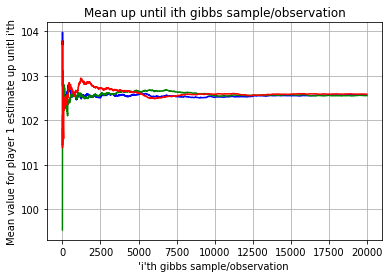

In [15]:
# Q.4a

plt.grid()
#plotting mean of all observed values up until the i'th obs

plt.plot(mean_vector_1[:20000], color='blue')
plt.plot(mean_vector_2[:20000], color='green')
plt.plot(mean_vector_3[:20000], color='red')


plt.title("Mean up until ith gibbs sample/observation")
plt.xlabel("'i'th gibbs sample/observation ")
plt.ylabel("Mean value for player 1 estimate up unitl i'th")


'''
Notes: 
Suitable burn-in value between 3000-5000.
For sake of computational resource efficienty, we choose 3000 as our burn-in value
''' 

Text(0.5, 1.0, '10000 samples after burn-in.')

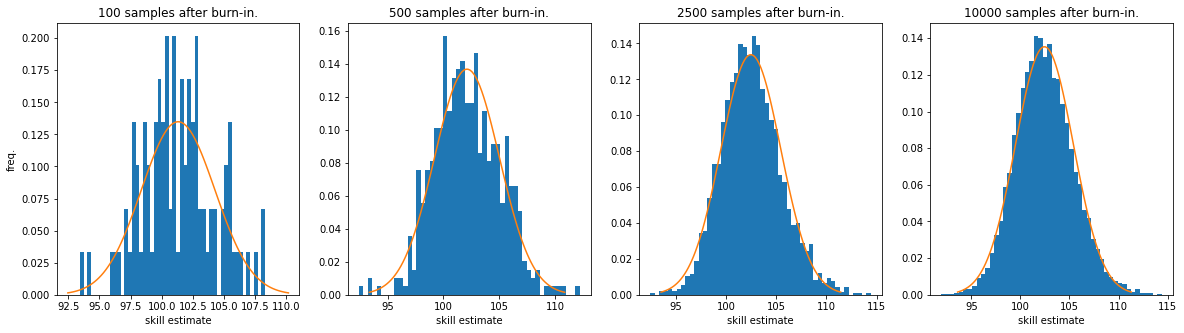

In [20]:
# Q.4a
burn_in_indx = 3000
nr_samples_q4c = 15000


s_obs, t_obs = gibbs_sampler(L=nr_samples_q4c,
                             player_1_stats=player_1_stats,
                             player_2_stats=player_2_stats,
                             t_game=match_outcome)

s_obs = s_obs[burn_in_indx:, :] # discard inital B samples due to burn in. 


player_1_stats_estimate_1, player_2_stats_estimate = player_stats_estimate_from_obs(s_obs=s_obs[burn_in_indx:burn_in_indx+100,:])
player_1_stats_estimate_2, player_2_stats_estimate = player_stats_estimate_from_obs(s_obs=s_obs[burn_in_indx:burn_in_indx+500, :])
player_1_stats_estimate_3, player_2_stats_estimate = player_stats_estimate_from_obs(s_obs=s_obs[burn_in_indx:burn_in_indx+2500, :])
player_1_stats_estimate_4, player_2_stats_estimate = player_stats_estimate_from_obs(s_obs=s_obs[burn_in_indx:burn_in_indx+10000, :])


p1_mu_est_1 = player_1_stats_estimate_1[0]
p1_var_est_1 = player_1_stats_estimate_1[1]
p1_sigma_est_1 = np.sqrt(p1_var_est_1)

p1_mu_est_2 = player_1_stats_estimate_2[0]
p1_var_est_2 = player_1_stats_estimate_2[1]
p1_sigma_est_2 = np.sqrt(p1_var_est_2)

p1_mu_est_3 = player_1_stats_estimate_3[0]
p1_var_est_3 = player_1_stats_estimate_3[1]
p1_sigma_est_3 = np.sqrt(p1_var_est_3)

p1_mu_est_4 = player_1_stats_estimate_4[0]
p1_var_est_4 = player_1_stats_estimate_4[1]
p1_sigma_est_4 = np.sqrt(p1_var_est_4)


x1 = np.linspace(p1_mu_est_1 - 3 * p1_sigma_est_1, p1_mu_est_1 + 3 * p1_sigma_est_1, 100)
x2 = np.linspace(p1_mu_est_2 - 3 * p1_sigma_est_2, p1_mu_est_2 + 3 * p1_sigma_est_2, 100)
x3 = np.linspace(p1_mu_est_3 - 3 * p1_sigma_est_3, p1_mu_est_3 + 3 * p1_sigma_est_3, 100)
x4 = np.linspace(p1_mu_est_4 - 3 * p1_sigma_est_4, p1_mu_est_4 + 3 * p1_sigma_est_4, 100)

plt.figure(figsize=[20,5])
plt.subplot(1,4, 1) 
plt.hist(s_obs[burn_in_indx:burn_in_indx+100, 0], bins=50, density=True) #P(S1 \Y=1)
plt.plot(x1, stats.norm.pdf(x1, loc = p1_mu_est_1, scale = p1_sigma_est_1))
plt.xlabel('skill estimate')
plt.ylabel('freq.')
plt.title('100 samples after burn-in.')

plt.subplot(1,4, 2) 
plt.hist(s_obs[burn_in_indx:burn_in_indx+500, 0], bins=50, density=True) #P(S1 \Y=1)
plt.plot(x2, stats.norm.pdf(x2, loc = p1_mu_est_2, scale = p1_sigma_est_2))
plt.xlabel('skill estimate')
plt.title('500 samples after burn-in.')

plt.subplot(1,4, 3) 
plt.hist(s_obs[burn_in_indx:burn_in_indx+3000, 0], bins=50, density=True) #P(S1 \Y=1)
plt.plot(x3, stats.norm.pdf(x3, loc = p1_mu_est_3, scale = p1_sigma_est_3))
plt.xlabel('skill estimate')
plt.title('2500 samples after burn-in.')

plt.subplot(1,4, 4) 
plt.hist(s_obs[burn_in_indx:burn_in_indx+10000, 0], bins=50, density=True) #P(S1 \Y=1)
plt.plot(x4, stats.norm.pdf(x4, loc = p1_mu_est_4, scale = p1_sigma_est_4))
plt.xlabel('skill estimate')
plt.ylabel('')
plt.title('10000 samples after burn-in.')


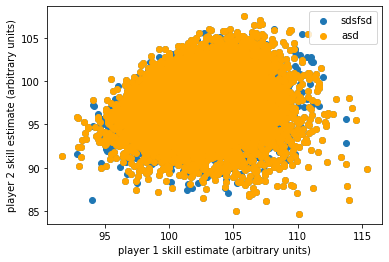

In [18]:
# Skill scatter plot for both players 
plt.figure
plt.scatter(s_obs[:,0], s_obs[:,1])
plt.scatter(s_obs[burn_in_indx:,0], s_obs[burn_in_indx:, 1], c='orange')
plt.xlabel('player 1 skill estimate (arbitrary units)')
plt.ylabel('player 2 skill estimate (arbitrary units)')
plt.legend({'asd', 'sdsfsd', 'asuhh '})


Text(0.5, 1.0, '2500 samples after burn-in.')

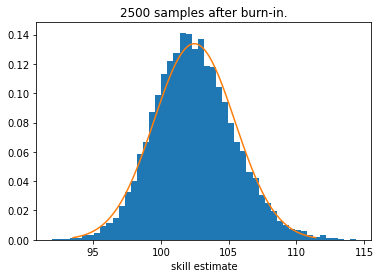

In [26]:



x_p_s1 = np.linspace(player_1_mean - 3 * np.sqrt(player_1_var), player_1_mean + 3 *np.sqrt(player_1_var), 100)
plt.plot(x3, stats.norm.pdf(x_p_s1, loc = player_1_mean, scale = np.sqrt(player_1_var)))

plt.xlabel('skill estimate')
plt.title('2500 samples after burn-in.')


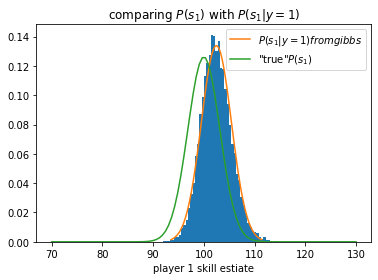

In [45]:
plt.hist(s_obs[burn_in_indx:burn_in_indx+25000, 0], bins=50, density=True) #P(S1 \Y=1)
plt.plot(x3, stats.norm.pdf(x3, loc = p1_mu_est_3, scale = p1_sigma_est_3), label='$P(s_{1}|y=1) from gibbs$')


x_p_s1 = np.linspace(player_1_mean - 3 * player_1_var, player_1_mean + 3 *player_1_var, 100)
plt.plot(x_p_s1, stats.norm.pdf(x_p_s1, loc = player_1_mean, scale = np.sqrt(player_1_var)), label='"true"$P(s_{1})$')

plt.title('comparing $P(s_{1})$ with $P(s_{1}|y=1)$')
plt.xlabel('probability/likelihood value')
plt.xlabel('player 1 skill estiate')
plt.legend()

In [50]:
np.min(t_obs)

0.0003958720415070949